# ARFs variant

## 1. Config Data

Luồng biến: Cell 2 → Cell 5,7,8,9,11,14,15 | Cell 7 → Cell 8,9 | Cell 9,11,14 → Cell 15

In [1]:
# Setup & Import
# --- OUT (dùng nhiều cell): X_phase0-2, y_phase0-2, X_test_encoded, y_test, TARGET_CLASSES, RANDOM_STATE,
#     row_to_dict, f1_cls, get_accuracy, get_macro_f1 ---
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# STRICT CONFIG
data_dir = Path(r'H:\tdc_window\Workspace\Testspace\ids\exp_data')
train_file = data_dir / 'KDDTrain+.txt'
test_file = data_dir / 'KDDTest+.txt'

categorical_cols = ['protocol_type', 'service', 'flag']
TARGET_CLASSES = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
RANDOM_STATE = 42

standard_column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty'
]

attack_categories = {
    'Normal': 'normal',
    'DoS': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'mailbomb', 'apache2', 'processtable', 'udpstorm'],
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],
    'R2L': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'sendmail', 'named', 'snmpgetattack', 'snmpguess', 'xlock', 'xsnoop', 'worm'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'httptunnel', 'ps', 'sqlattack', 'xterm']
}

print("Config loaded. TARGET_CLASSES:", TARGET_CLASSES)


# Load data & map attack_type -> label
def load_and_process_data(file_path, cols, mapping_dict, drop_difficulty=False):
    df = pd.read_csv(file_path, names=cols)
    df['attack_type'] = df['attack_type'].astype(str).str.strip().str.rstrip('.')
    reversed_mapping = {}
    for group, value in mapping_dict.items():
        if isinstance(value, list):
            for sub in value:
                reversed_mapping[sub] = group
        else:
            reversed_mapping[value] = group
    df['label'] = df['attack_type'].map(reversed_mapping).fillna('Unknown')
    if drop_difficulty:
        df = df.drop(columns=['difficulty'], errors='ignore')
    return df

train_df = load_and_process_data(train_file, standard_column_names, attack_categories)
test_df = load_and_process_data(test_file, standard_column_names, attack_categories)
print("train_df.shape:", train_df.shape)
print("test_df.shape:", test_df.shape)
print("\nTrain label counts:")
print(train_df['label'].value_counts())


# Encoding
exclude_cols = ['label', 'attack_type', 'difficulty']
X_train = train_df.drop(columns=exclude_cols)
X_test = test_df.drop(columns=exclude_cols)
y_train = train_df['label']
y_test = test_df['label']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, categorical_cols)],
    remainder='passthrough'
)
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print("X_train_encoded.shape:", X_train_encoded.shape)
print("X_test_encoded.shape:", X_test_encoded.shape)


# Phase split
mask_phase0 = y_train.isin(['Normal', 'DoS', 'Probe'])
mask_phase1 = (y_train == 'R2L')
mask_phase2 = (y_train == 'U2R')

X_phase0 = X_train_encoded[mask_phase0.values]
y_phase0 = y_train[mask_phase0].values
X_phase1 = X_train_encoded[mask_phase1.values]
y_phase1 = y_train[mask_phase1].values
X_phase2 = X_train_encoded[mask_phase2.values]
y_phase2 = y_train[mask_phase2].values

print("Phase 0:", X_phase0.shape[0], "samples")
print("Phase 1 (R2L):", X_phase1.shape[0], "samples")
print("Phase 2 (U2R):", X_phase2.shape[0], "samples")
print("Test set:", X_test_encoded.shape[0], "samples")


# River input format
def row_to_dict(row):
    return {f"f{i}": float(x) for i, x in enumerate(row)}

# Helpers cho metrics (dùng ở Cell 10, 12)
def f1_cls(report, cls):
    return report.get(cls, {}).get('f1-score', 0) or 0

def get_accuracy(report):
    return report.get('accuracy', 0) or 0

def get_macro_f1(report):
    return report.get('macro avg', {}).get('f1-score', 0) or 0

print("row_to_dict OK, example len:", len(row_to_dict(X_phase0[0])))

Config loaded. TARGET_CLASSES: ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
train_df.shape: (125973, 44)
test_df.shape: (22544, 44)

Train label counts:
label
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64
X_train_encoded.shape: (125973, 122)
X_test_encoded.shape: (22544, 122)
Phase 0: 124926 samples
Phase 1 (R2L): 995 samples
Phase 2 (U2R): 52 samples
Test set: 22544 samples
row_to_dict OK, example len: 122


### Lý do chọn River
- **River** là thư viện incremental/streaming ML cho Python, hỗ trợ `learn_one()`/`predict_one()` phù hợp với dữ liệu đến từng mẫu.
- **ARF (Adaptive Random Forest)** trong River dùng Hoeffding Tree + Leveraging Bagging, thiết kế cho concept drift.

### Cơ chế Drift Detection (ADWIN)
- **ADWIN (Adaptive Windowing)**: Giám sát thống kê (ví dụ: lỗi dự đoán) trong cửa sổ thích ứng. Khi phát hiện thay đổi phân phối → reset cây tương ứng.
- **drift_detector** (delta=0.001): Nhạy với drift chính.
- **warning_detector** (delta=0.01): Nhạy hơn để kích hoạt background tree. Khi warning → drift → thay cây cũ bằng background tree.

## 2. Định nghĩa ARF variants + predict_arf_batch

In [2]:
# --- IN: TARGET_CLASSES, RANDOM_STATE, row_to_dict (Cell 2)
#     OUT (dùng ở Cell 7, 8, 10): make_arf_base, make_arf_adwin, predict_arf_batch ---
from river import forest
from river import drift

N_MODELS = 100
GRACE_PERIOD = 50
SEED = RANDOM_STATE

def make_arf_base():
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=None,
        warning_detector=None,
    )

def make_arf_adwin():
    d = drift.ADWIN(delta=0.001)
    w = drift.ADWIN(delta=0.01)
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=w,
    )

def make_arf_kswin():
    d = drift.KSWIN(alpha=0.005)
    w = drift.KSWIN(alpha=0.01)
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=w,
    )

def make_arf_ph():
    d = drift.PageHinkley()
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=None,
    )

def make_arf_ddm():
    # sẽ sửa sau cho tương thích version River (DDM/HDDM)
    d = drift.DDM()
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=None,
    )

def make_arf_hddm_a():
    d = drift.HDDM_A()
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=None,
    )

def make_arf_hddm_w():
    d = drift.HDDM_W()
    return forest.ARFClassifier(
        n_models=N_MODELS,
        grace_period=GRACE_PERIOD,
        seed=SEED,
        drift_detector=d,
        warning_detector=None,
    )

VARIANTS = [
    ('ARF_Base', make_arf_base),
    ('ARF_ADWIN', make_arf_adwin),
    ('ARF_KSWIN', make_arf_kswin),
    ('ARF_PH', make_arf_ph),
    ('ARF_DDM', make_arf_ddm),
    ('ARF_HDDM_A', make_arf_hddm_a),
    ('ARF_HDDM_W', make_arf_hddm_w),
]
print("Variants:", [v[0] for v in VARIANTS])


def predict_arf_batch(model, X_test_encoded):
    preds = []
    for i in range(len(X_test_encoded)):
        x = row_to_dict(X_test_encoded[i])
        p = model.predict_one(x)
        preds.append(p if p is not None else TARGET_CLASSES[0])
    return preds

print("predict_arf_batch defined.")

Variants: ['ARF_Base', 'ARF_ADWIN', 'ARF_KSWIN', 'ARF_PH', 'ARF_DDM', 'ARF_HDDM_A', 'ARF_HDDM_W']
predict_arf_batch defined.


## 3. ARF_Base streaming P0->P1->P2 + classification_report sau mỗi phase

In [3]:
# --- IN: row_to_dict, predict_arf_batch, TARGET_CLASSES (Cell 2, 4)
#     OUT (dùng ở Cell 7, 8): train_arf_stream_with_eval_base
#     Trả về: rep0_text, rep1_text, rep2_text, rep0, rep1, rep2 (dict) ---
from sklearn.metrics import classification_report
import time
from tqdm.auto import tqdm

def train_arf_stream_with_eval_base(model,
                                    X_phase0, y_phase0,
                                    X_phase1, y_phase1,
                                    X_phase2, y_phase2,
                                    X_test_encoded, y_test,
                                    log_interval=20000):
    """Train 1 mô hình ARF_Base theo thứ tự P0 -> P1 -> P2 với tqdm progress bar.

    Sau mỗi phase, evaluate trên full test 5 lớp bằng classification_report.
    """
    print("=" * 80)
    print("Training ARF_Base with 3 phases (P0 -> P1 -> P2)")
    print("=" * 80)

    total_samples = len(X_phase0) + len(X_phase1) + len(X_phase2)
    processed = 0

    # Phase 0
    print(f"\n[Phase 0] Training on {len(X_phase0):,} samples (Normal, DoS, Probe)...")
    start = time.time()
    for i in tqdm(range(len(X_phase0)), desc="Phase 0", total=len(X_phase0)):
        model.learn_one(row_to_dict(X_phase0[i]), y_phase0[i])
        processed += 1
    t0 = time.time() - start
    print(f"[Phase 0] Done in {t0:.1f}s (processed {processed:,}/{total_samples:,} samples)")

    print("[Phase 0] Evaluating on full test set...")
    pred0 = predict_arf_batch(model, X_test_encoded)
    rep0_text = classification_report(y_test, pred0, labels=TARGET_CLASSES, zero_division=0)
    rep0 = classification_report(y_test, pred0, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print("\n=== ARF_Base - classification_report AFTER PHASE 0 ===")
    print(rep0_text)

    # Phase 1
    print(f"\n[Phase 1] Training on {len(X_phase1):,} samples (R2L only)...")
    start = time.time()
    for i in tqdm(range(len(X_phase1)), desc="Phase 1", total=len(X_phase1)):
        model.learn_one(row_to_dict(X_phase1[i]), y_phase1[i])
        processed += 1
    t1 = time.time() - start
    print(f"[Phase 1] Done in {t1:.1f}s (processed {processed:,}/{total_samples:,} samples)")

    print("[Phase 1] Evaluating on full test set...")
    pred1 = predict_arf_batch(model, X_test_encoded)
    rep1_text = classification_report(y_test, pred1, labels=TARGET_CLASSES, zero_division=0)
    rep1 = classification_report(y_test, pred1, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print("\n=== ARF_Base - classification_report AFTER PHASE 1 ===")
    print(rep1_text)

    # Phase 2
    print(f"\n[Phase 2] Training on {len(X_phase2):,} samples (U2R only)...")
    start = time.time()
    for i in tqdm(range(len(X_phase2)), desc="Phase 2", total=len(X_phase2)):
        model.learn_one(row_to_dict(X_phase2[i]), y_phase2[i])
        processed += 1
    t2 = time.time() - start
    print(f"[Phase 2] Done in {t2:.2f}s (processed {processed:,}/{total_samples:,} samples)")

    print("[Phase 2] Evaluating on full test set...")
    pred2 = predict_arf_batch(model, X_test_encoded)
    rep2_text = classification_report(y_test, pred2, labels=TARGET_CLASSES, zero_division=0)
    rep2 = classification_report(y_test, pred2, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print("\n=== ARF_Base - classification_report AFTER PHASE 2 ===")
    print(rep2_text)

    print("\n" + "=" * 80)
    print("ARF_Base training timeline:")
    print(f"  Phase 0: {t0:.1f}s   Phase 1: {t1:.1f}s   Phase 2: {t2:.2f}s")
    print("=" * 80)

    return rep0_text, rep1_text, rep2_text, rep0, rep1, rep2

In [4]:
# --- IN: make_arf_base (Cell 4), train_arf_stream_with_eval_base (Cell 6),
#     X_phase0-2, y_phase0-2, X_test_encoded, y_test (Cell 2)
#     OUT (dùng ở Cell 12): rep0_base, rep1_base, rep2_base ---
# Chạy ARF_Base (no-replay) — trước khắc phục
model_base_stream = make_arf_base()
rep0_text, rep1_text, rep2_text, rep0_base, rep1_base, rep2_base = train_arf_stream_with_eval_base(
    model_base_stream,
    X_phase0, y_phase0,
    X_phase1, y_phase1,
    X_phase2, y_phase2,
    X_test_encoded, y_test,
    log_interval=20000,
)

Training ARF_Base with 3 phases (P0 -> P1 -> P2)

[Phase 0] Training on 124,926 samples (Normal, DoS, Probe)...


Phase 0:   0%|          | 0/124926 [00:00<?, ?it/s]

[Phase 0] Done in 2346.9s (processed 124,926/125,973 samples)
[Phase 0] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 0 ===
              precision    recall  f1-score   support

      Normal       0.64      0.97      0.77      9711
         DoS       0.96      0.79      0.87      7458
       Probe       0.86      0.61      0.71      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.49      0.47      0.47     22544
weighted avg       0.69      0.75      0.70     22544


[Phase 1] Training on 995 samples (R2L only)...


Phase 1:   0%|          | 0/995 [00:00<?, ?it/s]

[Phase 1] Done in 4.6s (processed 125,921/125,973 samples)
[Phase 1] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 1 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.12      1.00      0.22      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.12     22544
   macro avg       0.02      0.20      0.04     22544
weighted avg       0.01      0.12      0.03     22544


[Phase 2] Training on 52 samples (U2R only)...


Phase 2:   0%|          | 0/52 [00:00<?, ?it/s]

[Phase 2] Done in 0.38s (processed 125,973/125,973 samples)
[Phase 2] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 2 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.01      1.00      0.02       200

    accuracy                           0.01     22544
   macro avg       0.00      0.20      0.00     22544
weighted avg       0.00      0.01      0.00     22544


ARF_Base training timeline:
  Phase 0: 2346.9s   Phase 1: 4.6s   Phase 2: 0.38s


In [8]:
## 4. ARF_ADWIN streaming P0 -> P1 -> P2 + classification_report sau mỗi phase

# --- IN: make_arf_adwin, train_arf_stream_with_eval_base (Cell 4, 6),
#     X_phase0-2, y_phase0-2, X_test_encoded, y_test (Cell 2)
#     OUT (dùng ở Cell 12): rep0_adwin, rep1_adwin, rep2_adwin ---

print("\n\n" + "#" * 80)
print("# ARF_ADWIN – streaming P0 -> P1 -> P2")
print("#" * 80)

# Khởi tạo mô hình ARF_ADWIN
model_adwin_stream = make_arf_adwin()

# Train tuần tự 3 phase và in classification_report sau mỗi phase
rep0_adwin_text, rep1_adwin_text, rep2_adwin_text, rep0_adwin, rep1_adwin, rep2_adwin = train_arf_stream_with_eval_base(
    model_adwin_stream,
    X_phase0, y_phase0,   # Phase 0: Normal/DoS/Probe
    X_phase1, y_phase1,   # Phase 1: R2L
    X_phase2, y_phase2,   # Phase 2: U2R
    X_test_encoded,       # Full test 5 lớp
    y_test,
    log_interval=20000,   # mỗi 20k mẫu log 1 lần ở Phase 0
)



################################################################################
# ARF_ADWIN – streaming P0 -> P1 -> P2
################################################################################
Training ARF_Base with 3 phases (P0 -> P1 -> P2)

[Phase 0] Training on 124,926 samples (Normal, DoS, Probe)...


Phase 0:   0%|          | 0/124926 [00:00<?, ?it/s]

[Phase 0] Done in 2310.8s (processed 124,926/125,973 samples)
[Phase 0] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 0 ===
              precision    recall  f1-score   support

      Normal       0.64      0.97      0.77      9711
         DoS       0.96      0.79      0.87      7458
       Probe       0.86      0.61      0.71      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.49      0.47      0.47     22544
weighted avg       0.69      0.75      0.70     22544


[Phase 1] Training on 995 samples (R2L only)...


Phase 1:   0%|          | 0/995 [00:00<?, ?it/s]

[Phase 1] Done in 5.6s (processed 125,921/125,973 samples)
[Phase 1] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 1 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.12      1.00      0.22      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.12     22544
   macro avg       0.02      0.20      0.04     22544
weighted avg       0.01      0.12      0.03     22544


[Phase 2] Training on 52 samples (U2R only)...


Phase 2:   0%|          | 0/52 [00:00<?, ?it/s]

[Phase 2] Done in 0.48s (processed 125,973/125,973 samples)
[Phase 2] Evaluating on full test set...

=== ARF_Base - classification_report AFTER PHASE 2 ===
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00      9711
         DoS       0.00      0.00      0.00      7458
       Probe       0.00      0.00      0.00      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.01      1.00      0.02       200

    accuracy                           0.01     22544
   macro avg       0.00      0.20      0.00     22544
weighted avg       0.00      0.01      0.00     22544


ARF_Base training timeline:
  Phase 0: 2310.8s   Phase 1: 5.6s   Phase 2: 0.48s


## 5. ARF + Replay Buffer (giải pháp khắc phục Catastrophic Forgetting)

Replay-based: Lưu buffer mẫu từ phase cũ, đan xen khi học phase mới để mô hình không quên kiến thức cũ.

In [6]:
# --- ARF + Replay Buffer ---
# IN: X_phase0-2, y_phase0-2, X_test_encoded, y_test, RANDOM_STATE (Cell 2),
#     row_to_dict, predict_arf_batch, make_arf_base, TARGET_CLASSES (Cell 2, 4)
# OUT (dùng ở Cell 12): rep0_r, rep1_r, rep2_r
# Buffer: P0 ~5,000 mẫu (~4%); P1 ~200 mẫu (~20%).
#
import numpy as np
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

REPLAY_P0_SIZE = 5_000   # buffer từ Phase 0 (Normal/DoS/Probe)
REPLAY_P1_SIZE = 200     # buffer từ Phase 1 (R2L) - dùng khi học Phase 2
REPLAY_RATIO = 0.4       # tỷ lệ replay: mỗi N mẫu mới thì inject ~N*REPLAY_RATIO mẫu replay

np.random.seed(RANDOM_STATE)

# 1. Tạo replay buffer từ Phase 0 (stratified: giữ tỷ lệ Normal/DoS/Probe)
n_p0 = len(X_phase0)
idx_p0 = np.random.choice(n_p0, size=min(REPLAY_P0_SIZE, n_p0), replace=False)
X_replay_p0 = X_phase0[idx_p0]
y_replay_p0 = y_phase0[idx_p0]

# 2. Tạo replay buffer từ Phase 1 (cho khi học Phase 2)
n_p1 = len(X_phase1)
idx_p1 = np.random.choice(n_p1, size=min(REPLAY_P1_SIZE, n_p1), replace=False)
X_replay_p1 = X_phase1[idx_p1]
y_replay_p1 = y_phase1[idx_p1]

print(f"Replay buffer P0: {len(X_replay_p0):,} samples")
print(f"Replay buffer P1: {len(X_replay_p1):,} samples")


def train_arf_with_replay(model,
                           X_phase0, y_phase0,
                           X_phase1, y_phase1,
                           X_phase2, y_phase2,
                           X_replay_p0, y_replay_p0,
                           X_replay_p1, y_replay_p1,
                           X_test_encoded, y_test,
                           replay_ratio=REPLAY_RATIO):
    """ARF streaming P0 -> P1 -> P2, với replay buffer đan xen khi học P1 và P2."""
    print("=" * 80)
    print("Training ARF + Replay Buffer (P0 -> P1+replay -> P2+replay)")
    print("=" * 80)

    # Phase 0: học bình thường
    print(f"\n[Phase 0] Training on {len(X_phase0):,} samples (Normal, DoS, Probe)...")
    for i in tqdm(range(len(X_phase0)), desc="Phase 0", total=len(X_phase0)):
        model.learn_one(row_to_dict(X_phase0[i]), y_phase0[i])
    pred0 = predict_arf_batch(model, X_test_encoded)
    rep0 = classification_report(y_test, pred0, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print(classification_report(y_test, pred0, labels=TARGET_CLASSES, zero_division=0))

    # Phase 1: đan xen mỗi mẫu P1 với replay từ P0
    print(f"\n[Phase 1] Training on {len(X_phase1):,} P1 + replay P0...")
    n_replay = len(X_replay_p0)
    for i in tqdm(range(len(X_phase1)), desc="Phase 1", total=len(X_phase1)):
        model.learn_one(row_to_dict(X_phase1[i]), y_phase1[i])
        # Mỗi mẫu P1: với xác suất replay_ratio, inject 1 mẫu replay từ P0
        if np.random.random() < replay_ratio:
            j = np.random.randint(0, n_replay)
            model.learn_one(row_to_dict(X_replay_p0[j]), y_replay_p0[j])
    pred1 = predict_arf_batch(model, X_test_encoded)
    rep1 = classification_report(y_test, pred1, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print(classification_report(y_test, pred1, labels=TARGET_CLASSES, zero_division=0))

    # Phase 2: đan xen mỗi mẫu P2 với replay từ P0 và P1
    print(f"\n[Phase 2] Training on {len(X_phase2):,} P2 + replay P0+P1...")
    n_replay_p1 = len(X_replay_p1)
    for i in tqdm(range(len(X_phase2)), desc="Phase 2", total=len(X_phase2)):
        model.learn_one(row_to_dict(X_phase2[i]), y_phase2[i])
        # Với xác suất replay_ratio, inject 1 mẫu từ P0 và 1 từ P1
        if np.random.random() < replay_ratio:
            j = np.random.randint(0, n_replay)
            model.learn_one(row_to_dict(X_replay_p0[j]), y_replay_p0[j])
        if np.random.random() < replay_ratio:
            j1 = np.random.randint(0, n_replay_p1)
            model.learn_one(row_to_dict(X_replay_p1[j1]), y_replay_p1[j1])
    pred2 = predict_arf_batch(model, X_test_encoded)
    rep2 = classification_report(y_test, pred2, labels=TARGET_CLASSES, output_dict=True, zero_division=0)
    print(classification_report(y_test, pred2, labels=TARGET_CLASSES, zero_division=0))

    return rep0, rep1, rep2


# Chạy ARF + Replay
model_arf_replay = make_arf_base()
rep0_r, rep1_r, rep2_r = train_arf_with_replay(
    model_arf_replay,
    X_phase0, y_phase0, X_phase1, y_phase1, X_phase2, y_phase2,
    X_replay_p0, y_replay_p0, X_replay_p1, y_replay_p1,
    X_test_encoded, y_test,
    replay_ratio=REPLAY_RATIO,
)

# --- So sánh F1 đủ 5 lớp + Accuracy, Macro F1 (dùng f1_cls, get_accuracy, get_macro_f1 từ Cell 2) ---
# Bảng F1 theo từng lớp, sau mỗi phase
print("\n" + "=" * 70)
print("F1 theo từng lớp sau mỗi phase (ARF + Replay)")
print("=" * 70)
print(f"{'Class':<10} {'After P0':>10} {'After P1':>10} {'After P2':>10}")
print("-" * 50)
for cls in TARGET_CLASSES:
    f0 = f1_cls(rep0_r, cls)
    f1 = f1_cls(rep1_r, cls)
    f2 = f1_cls(rep2_r, cls)
    print(f"{cls:<10} {f0:>10.4f} {f1:>10.4f} {f2:>10.4f}")

# Accuracy & Macro F1 tổng thể
print("\n" + "=" * 60)
print("Accuracy & Macro F1 tổng thể (5 lớp)")
print("=" * 60)
for name, rep in [("After P0", rep0_r), ("After P1", rep1_r), ("After P2", rep2_r)]:
    acc = get_accuracy(rep)
    macro = get_macro_f1(rep)
    print(f"  {name}: Accuracy = {acc:.4f}, Macro F1 = {macro:.4f}")

# R2L: Forgetting khi học Phase 2 (P1 → P2)
f1_r2l_p1 = f1_cls(rep1_r, 'R2L')
f1_r2l_p2 = f1_cls(rep2_r, 'R2L')
forget_r2l = f1_r2l_p1 - f1_r2l_p2
print(f"\nR2L (Phase 1 class): F1_P1 = {f1_r2l_p1:.4f}, F1_P2 = {f1_r2l_p2:.4f}, Forgetting (P1→P2) = {forget_r2l:.4f}")

Replay buffer P0: 5,000 samples
Replay buffer P1: 200 samples
Training ARF + Replay Buffer (P0 -> P1+replay -> P2+replay)

[Phase 0] Training on 124,926 samples (Normal, DoS, Probe)...


Phase 0:   0%|          | 0/124926 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      Normal       0.64      0.97      0.77      9711
         DoS       0.96      0.79      0.87      7458
       Probe       0.86      0.61      0.71      2421
         R2L       0.00      0.00      0.00      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.49      0.47      0.47     22544
weighted avg       0.69      0.75      0.70     22544


[Phase 1] Training on 995 P1 + replay P0...


Phase 1:   0%|          | 0/995 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      Normal       0.69      0.96      0.80      9711
         DoS       0.81      0.74      0.77      7458
       Probe       0.85      0.05      0.10      2421
         R2L       0.54      0.41      0.47      2754
         U2R       0.00      0.00      0.00       200

    accuracy                           0.71     22544
   macro avg       0.58      0.43      0.43     22544
weighted avg       0.72      0.71      0.67     22544


[Phase 2] Training on 52 P2 + replay P0+P1...


Phase 2:   0%|          | 0/52 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      Normal       0.73      0.94      0.82      9711
         DoS       0.85      0.76      0.81      7458
       Probe       0.96      0.16      0.27      2421
         R2L       0.44      0.46      0.45      2754
         U2R       0.46      0.18      0.26       200

    accuracy                           0.73     22544
   macro avg       0.69      0.50      0.52     22544
weighted avg       0.76      0.73      0.71     22544


F1 theo từng lớp sau mỗi phase (ARF + Replay)
Class        After P0   After P1   After P2
--------------------------------------------------
Normal         0.7749     0.8009     0.8245
DoS            0.8659     0.7721     0.8052
Probe          0.7141     0.0959     0.2686
R2L            0.0000     0.4662     0.4483
U2R            0.0000     0.0000     0.2643

Accuracy & Macro F1 tổng thể (5 lớp)
  After P0: Accuracy = 0.7461, Macro F1 = 0.4710
  After P1: Accuracy = 0.7124, Macro F1 = 0.4270
  After P2: A

## 6. So sánh metrics: AA, FM, BWT trước/sau khắc phục

- **AA (Average Accuracy):** Accuracy cuối sau Phase 2 trên 5 lớp
- **FM (Forgetting Measure):** F1(baseline) - F1(sau cùng) cho từng lớp cũ
- **BWT (Backward Transfer):** F1(sau cùng) - F1(baseline)

So sánh: Task2 (Accumulated, Naive) | ARF Base | ARF ADWIN | ARF + Replay

### Task 2 baselines (tham khảo 02_stimulate_CF.ipynb)
Chạy sklearn RF: Accumulated (P0+P1+P2) và Naive (chỉ P2). Nhanh (~1–2 phút), dùng làm benchmark.

In [11]:
# --- Task 2 baselines: Naive & Accumulated (sklearn RF batch) ---
# Tham khảo 02_stimulate_CF.ipynb. Chạy nhanh (~1-2 phút), không cần chạy lại ARF.
from sklearn.ensemble import RandomForestClassifier

# Accumulated: train P0+P1+P2 cùng lúc (optimal, không quên)
rf_acc = RandomForestClassifier(random_state=RANDOM_STATE)
rf_acc.fit(np.vstack([X_phase0, X_phase1, X_phase2]),
           np.concatenate([y_phase0, y_phase1, y_phase2]))
pred_acc = rf_acc.predict(X_test_encoded)
rep_acc = classification_report(y_test, pred_acc, labels=TARGET_CLASSES, output_dict=True, zero_division=0)

# Naive: train chỉ P2 (mô phỏng CF cực đoan - quên hết)
rf_naive = RandomForestClassifier(random_state=RANDOM_STATE)
rf_naive.fit(X_phase2, y_phase2)
pred_naive = rf_naive.predict(X_test_encoded)
rep_naive = classification_report(y_test, pred_naive, labels=TARGET_CLASSES, output_dict=True, zero_division=0)

aa_acc = rep_acc.get('accuracy', 0)
aa_naive = rep_naive.get('accuracy', 0)
macro_acc = get_macro_f1(rep_acc)
macro_naive = get_macro_f1(rep_naive)
print("Task 2 baselines - Accuracy: Accumulated =", f"{aa_acc:.4f}", ", Naive(P2-only) =", f"{aa_naive:.4f}")

Task 2 baselines - Accuracy: Accumulated = 0.7431 , Naive(P2-only) = 0.0089


In [10]:
# --- IN: rep0_base, rep1_base, rep2_base (Cell 7), rep0_adwin, rep1_adwin, rep2_adwin (Cell 8),
#     rep0_r, rep1_r, rep2_r (Cell 11), aa_acc, aa_naive, macro_acc, macro_naive (Cell 13),
#     TARGET_CLASSES (Cell 2)
#     OUT: aa_before, fm_before, macro_before, aa_adwin, fm_adwin, macro_adwin, aa_after, fm_after, macro_after ---
# Tính AA, FM, BWT cho cả ARF no-replay (trước) và ARF + Replay (sau)
# Dùng f1_cls từ Cell 2

def compute_aa_fm_bwt(rep0, rep1, rep2):
    """Tính AA, FM trung bình, Macro F1 từ rep0, rep1, rep2 (output_dict)."""
    aa = rep2.get('accuracy', 0) or 0
    macro_f1 = rep2.get('macro avg', {}).get('f1-score', 0) or 0
    fm_sum = 0
    n_old = 0
    for cls in TARGET_CLASSES:
        if cls in ['Normal', 'DoS', 'Probe']:
            base_rep = rep0
        elif cls == 'R2L':
            base_rep = rep1
        else:
            base_rep = None
        f1_base = f1_cls(base_rep, cls) if base_rep is not None else 0
        f1_final = f1_cls(rep2, cls)
        fm = f1_base - f1_final
        if cls in ['Normal', 'DoS', 'Probe', 'R2L']:
            fm_sum += fm
            n_old += 1
    fm_avg = fm_sum / n_old if n_old > 0 else 0
    return aa, fm_avg, macro_f1

# --- Trước: ARF no-replay (Base) ---
aa_before, fm_before, macro_before = compute_aa_fm_bwt(rep0_base, rep1_base, rep2_base)

# --- ARF_ADWIN (no-replay) ---
aa_adwin, fm_adwin, macro_adwin = compute_aa_fm_bwt(rep0_adwin, rep1_adwin, rep2_adwin)

# --- Sau: ARF + Replay ---
aa_after, fm_after, macro_after = compute_aa_fm_bwt(rep0_r, rep1_r, rep2_r)

# --- Bảng so sánh trước/sau khắc phục (kèm Task 2 baselines) ---
print("=" * 70)
print("So sánh AA, FM, BWT trước/sau khắc phục")
print("=" * 70)
print(f"{'Phương pháp':<30} {'AA':>10} {'FM trung bình':>16} {'Macro F1':>12}")
print("-" * 70)
print(f"{'Task2 Accumulated':<30} {aa_acc:>10.4f} {'N/A':>16} {macro_acc:>12.4f}")
print(f"{'Task2 Naive (P2-only)':<30} {aa_naive:>10.4f} {'N/A':>16} {macro_naive:>12.4f}")
print(f"{'ARF Base (no-replay)':<30} {aa_before:>10.4f} {fm_before:>16.4f} {macro_before:>12.4f}")
print(f"{'ARF ADWIN (no-replay)':<30} {aa_adwin:>10.4f} {fm_adwin:>16.4f} {macro_adwin:>12.4f}")
print(f"{'ARF + Replay (sau)':<30} {aa_after:>10.4f} {fm_after:>16.4f} {macro_after:>12.4f}")
print("-" * 70)

# Chi tiết FM & BWT theo lớp (ARF + Replay)
print("\n" + "=" * 70)
print("FM & BWT theo lớp (ARF + Replay)")
print("=" * 70)
print(f"{'Class':<10} {'Baseline F1':>12} {'Final F1':>12} {'FM':>10} {'BWT':>10}")
print("-" * 58)
fm_sum = 0
n_old = 0
for cls in TARGET_CLASSES:
    if cls in ['Normal', 'DoS', 'Probe']:
        base_rep = rep0_r
    elif cls == 'R2L':
        base_rep = rep1_r
    else:
        base_rep = None
    f1_base = f1_cls(base_rep, cls) if base_rep is not None else 0
    f1_final = f1_cls(rep2_r, cls)
    fm = f1_base - f1_final
    bwt = f1_final - f1_base
    if cls in ['Normal', 'DoS', 'Probe', 'R2L']:
        fm_sum += fm
        n_old += 1
    print(f"{cls:<10} {f1_base:>12.4f} {f1_final:>12.4f} {fm:>10.4f} {bwt:>10.4f}")
fm_avg = fm_sum / n_old if n_old > 0 else 0
print("-" * 58)
print(f"FM trung bình (4 lớp cũ): {fm_avg:.4f}")

So sánh AA, FM, BWT trước/sau khắc phục
Phương pháp                            AA    FM trung bình     Macro F1
----------------------------------------------------------------------
ARF Base (no-replay)               0.0089           0.6431       0.0035
ARF ADWIN (no-replay)              0.0089           0.6431       0.0035
ARF + Replay (sau)                 0.7330           0.1187       0.5222
----------------------------------------------------------------------

FM & BWT theo lớp (ARF + Replay)
Class       Baseline F1     Final F1         FM        BWT
----------------------------------------------------------
Normal           0.7749       0.8245    -0.0496     0.0496
DoS              0.8659       0.8052     0.0607    -0.0607
Probe            0.7141       0.2686     0.4455    -0.4455
R2L              0.4662       0.4483     0.0180    -0.0180
U2R              0.0000       0.2643    -0.2643     0.2643
----------------------------------------------------------
FM trung bình (4 lớp cũ)

In [ ]:
## Output báo cáo

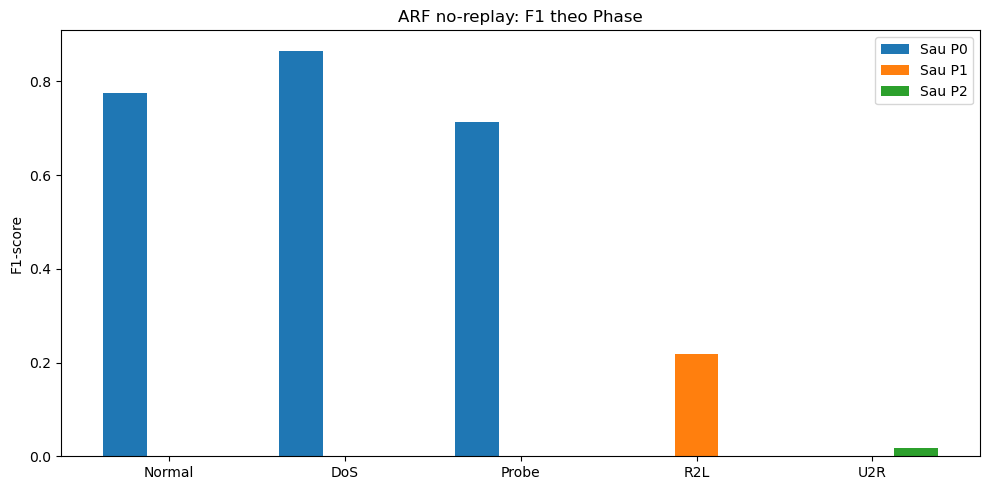

In [12]:
import matplotlib.pyplot as plt
import numpy as np

classes = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
f1_p0 = [f1_cls(rep0_base, c) for c in classes]
f1_p1 = [f1_cls(rep1_base, c) for c in classes]
f1_p2 = [f1_cls(rep2_base, c) for c in classes]

x = np.arange(len(classes))
w = 0.25
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - w, f1_p0, w, label='Sau P0')
ax.bar(x, f1_p1, w, label='Sau P1')
ax.bar(x + w, f1_p2, w, label='Sau P2')
ax.set_xticks(x); ax.set_xticklabels(classes)
ax.set_ylabel('F1-score'); ax.legend(); ax.set_title('ARF no-replay: F1 theo Phase')
plt.tight_layout(); plt.savefig('arf_no_replay_f1_by_phase.png', dpi=150); plt.show()

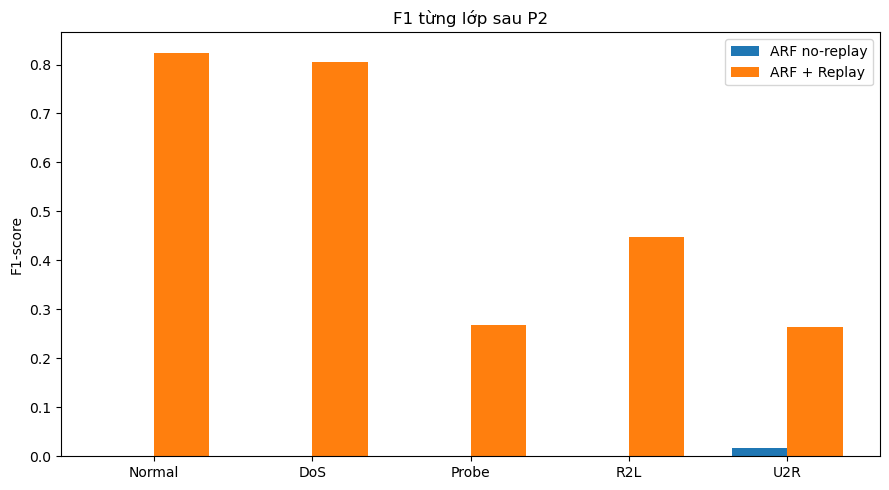

In [13]:
# So sánh F1 sau P2: ARF no-replay vs ARF + Replay
f1_base = [f1_cls(rep2_base, c) for c in TARGET_CLASSES]
f1_replay = [f1_cls(rep2_r, c) for c in TARGET_CLASSES]

x = np.arange(len(TARGET_CLASSES))
w = 0.35
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - w/2, f1_base, w, label='ARF no-replay')
ax.bar(x + w/2, f1_replay, w, label='ARF + Replay')
ax.set_xticks(x); ax.set_xticklabels(TARGET_CLASSES)
ax.set_ylabel('F1-score'); ax.legend(); ax.set_title('F1 từng lớp sau P2')
plt.tight_layout(); plt.savefig('arf_no_replay_vs_replay_f1.png', dpi=150); plt.show()